##6.1 Prepare train candidates for Reranker

**Two step Reranker** <br>
To handle a recommender with a large dataset, a two step approach is usually done:
1. Ranking for candidates generation. This step narrows down the number of possible candidates significantly. We will prepare 30 products per user due to resource constraints, but the top scoring models should use much more (e.g. 200 per user or more). 
2. Reranking using a Ranking Model to get 20 products per user. We will have to find user/item/user-item features to train the model, as to be elaborated in Part 6.3.

As mentioned, a reranker requires far more steps (and each step to be done correctly) than a rule-based model. Also, it is a black box model which is harder to explain. However, it can theoretically improve the score of a rule-based approach further.

Due to resources constraints again, we will focus on Orders only. Improving clicks will improve engagement, but orders are actual sales so we want to focus on this.

**Set up rapids and GPU**

In [ ]:
# Run this to check if GPU is used
!nvidia-smi

Sat Apr 15 22:17:46 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    48W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Run this each time to get the RAPIDS-Colab install files and test check GPU
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py


Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 385, done.
remote: Counting objects: 100% (116/116), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 385 (delta 86), reused 51 (delta 51), pack-reused 269
Receiving objects: 100% (385/385), 105.74 KiB | 2.16 MiB/s, done.
Resolving deltas: 100% (188/188), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.0 MB/s eta 0:00:00
***********************************************************************
Woo! Your instance has the right kind of GPU, a NVIDIA A100-SXM4-40GB!
We will now install RAPIDS cuDF, cuML, and cuGraph via pip! 
Please stand by, should be quick...
***********************************************************************

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

**Prepare files**

In [ ]:
VER = 4

import pandas as pd, numpy as np
import seaborn as sns
from tqdm.notebook import tqdm
import os, sys, pickle, glob, gc
from collections import Counter

# !pip install pandarallel
from pandarallel import pandarallel
import cudf, itertools
print('We will use RAPIDS version',cudf.__version__)

We will use RAPIDS version 23.04.00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%time
# CACHE FUNCTIONS
def read_file(f):
    return cudf.DataFrame( data_cache[f] )
def read_file_to_cache(f):
    df = pd.read_parquet(f)
    df.ts = (df.ts/1000).astype('int32')
    df['type'] = df['type'].map(type_labels).astype('int8')
    return df

# CACHE THE DATA ON CPU BEFORE PROCESSING ON GPU
data_cache = {}
type_labels = {'clicks':0, 'carts':1, 'orders':2}

# we use only those from train dataset (weeks 1 to 4)
files = glob.glob('/content/drive/MyDrive/0.capstone/covisit_prepare/validation/*_parquet/*')
for f in files: data_cache[f] = read_file_to_cache(f)

# CHUNK PARAMETERS
READ_CT = 5
CHUNK = int( np.ceil( len(files) / 6 ))
print(f'We will process {len(files)} files, in groups of {READ_CT} and chunks of {CHUNK}.')

We will process 111 files, in groups of 5 and chunks of 19.
CPU times: user 19.9 s, sys: 4.1 s, total: 24 s
Wall time: 54.7 s


**Covisitation 1: "Carts Orders" Co-visitation Matrix - Type Weighted**

- Split into parts to prevent memory errors
- Select the up to 30 most recent click, cart, orders
- Identify pairs that occurred within one day
- wgt = frequency of interaction of each pair, weighted by type of aid_y
- output top 30 pairs of each aid_x by weight *(this was increased vs rule based approach)*

In [ ]:
%%time
type_weight = {0:0.5, 1:9, 2:2}

# USE SMALLEST DISK_PIECES POSSIBLE WITHOUT MEMORY ERROR
DISK_PIECES = 2
SIZE = 1.86e6/DISK_PIECES

# COMPUTE IN PARTS FOR MEMORY MANGEMENT
for PART in range(DISK_PIECES):
    print()
    print('### DISK PART',PART+1)
    
    # MERGE IS FASTEST PROCESSING CHUNKS WITHIN CHUNKS
    # => OUTER CHUNKS
    for j in range(6):
        a = j*CHUNK
        b = min( (j+1)*CHUNK, len(files) )
        print(f'Processing files {a} thru {b-1} in groups of {READ_CT}...')
        
        # => INNER CHUNKS
        for k in range(a,b,READ_CT):
            # READ FILE
            df = [read_file(files[k])]
            for i in range(1,READ_CT): 
                if k+i<b: df.append( read_file(files[k+i]) )
            df = cudf.concat(df,ignore_index=True,axis=0)
            df = df.sort_values(['session','ts'],ascending=[True,False])
            # USE TAIL OF SESSION
            df = df.reset_index(drop=True)
            df['n'] = df.groupby('session').cumcount()
            df = df.loc[df.n<30].drop('n',axis=1)
            # CREATE PAIRS
            df = df.merge(df,on='session')
            df = df.loc[ ((df.ts_x - df.ts_y).abs()< 24 * 60 * 60) & (df.aid_x != df.aid_y) ]
            # MEMORY MANAGEMENT COMPUTE IN PARTS
            df = df.loc[(df.aid_x >= PART*SIZE)&(df.aid_x < (PART+1)*SIZE)]
            # ASSIGN WEIGHTS
            df = df[['session', 'aid_x', 'aid_y','type_y']].drop_duplicates(['session', 'aid_x', 'aid_y','type_y'])
            df['wgt'] = df.type_y.map(type_weight)
            df = df[['aid_x','aid_y','wgt']]
            df.wgt = df.wgt.astype('float32')
            df = df.groupby(['aid_x','aid_y']).wgt.sum()
            # COMBINE INNER CHUNKS
            if k==a: tmp2 = df
            else: tmp2 = tmp2.add(df, fill_value=0)
            print(k,', ',end='')
        print()
        # COMBINE OUTER CHUNKS
        if a==0: tmp = tmp2
        else: tmp = tmp.add(tmp2, fill_value=0)
        del tmp2, df
        gc.collect()
    # CONVERT MATRIX TO DICTIONARY
    tmp = tmp.reset_index()
    tmp = tmp.sort_values(['aid_x','wgt'],ascending=[True,False])
    # SAVE TOP 30
    tmp = tmp.reset_index(drop=True)
    tmp['n'] = tmp.groupby('aid_x').aid_y.cumcount()
    tmp = tmp.loc[tmp.n<30].drop('n',axis=1)
    # SAVE PART TO DISK (convert to pandas first uses less memory)
    tmp.to_pandas().to_parquet(f'/content/drive/MyDrive/0.capstone/covisit_prepare/top_30_carts_orders_v{VER}_{PART}.parquet')


### DISK PART 1
Processing files 0 thru 18 in groups of 5...
0 , 5 , 10 , 15 , 
Processing files 19 thru 37 in groups of 5...
19 , 24 , 29 , 34 , 
Processing files 38 thru 56 in groups of 5...
38 , 43 , 48 , 53 , 
Processing files 57 thru 75 in groups of 5...
57 , 62 , 67 , 72 , 
Processing files 76 thru 94 in groups of 5...
76 , 81 , 86 , 91 , 
Processing files 95 thru 110 in groups of 5...
95 , 100 , 105 , 110 , 

### DISK PART 2
Processing files 0 thru 18 in groups of 5...
0 , 5 , 10 , 15 , 
Processing files 19 thru 37 in groups of 5...
19 , 24 , 29 , 34 , 
Processing files 38 thru 56 in groups of 5...
38 , 43 , 48 , 53 , 
Processing files 57 thru 75 in groups of 5...
57 , 62 , 67 , 72 , 
Processing files 76 thru 94 in groups of 5...
76 , 81 , 86 , 91 , 
Processing files 95 thru 110 in groups of 5...
95 , 100 , 105 , 110 , 
CPU times: user 35.6 s, sys: 8.42 s, total: 44 s
Wall time: 1min 2s


**Covisitation 2: "Buy2Buy" Co-visitation Matrix**

- Split into parts to prevent memory errors
- Select the up to 30 most recent cart, orders only
- Identify pairs that occurred within 14 days
- wgt = frequency of interaction of each pair
- output top 30 pairs of each aid_x by weight *(this was increased vs rule based approach)*

In [ ]:
%%time
# USE SMALLEST DISK_PIECES POSSIBLE WITHOUT MEMORY ERROR
DISK_PIECES = 1
SIZE = 1.86e6/DISK_PIECES

# COMPUTE IN PARTS FOR MEMORY MANGEMENT
for PART in range(DISK_PIECES):
    print()
    print('### DISK PART',PART+1)
    
    # MERGE IS FASTEST PROCESSING CHUNKS WITHIN CHUNKS
    # => OUTER CHUNKS
    for j in range(6):
        a = j*CHUNK
        b = min( (j+1)*CHUNK, len(files) )
        print(f'Processing files {a} thru {b-1} in groups of {READ_CT}...')
        
        # => INNER CHUNKS
        for k in range(a,b,READ_CT):
            # READ FILE
            df = [read_file(files[k])]
            for i in range(1,READ_CT): 
                if k+i<b: df.append( read_file(files[k+i]) )
            df = cudf.concat(df,ignore_index=True,axis=0)
            df = df.loc[df['type'].isin([1,2])] # ONLY WANT CARTS AND ORDERS
            df = df.sort_values(['session','ts'],ascending=[True,False])
            # USE TAIL OF SESSION
            df = df.reset_index(drop=True)
            df['n'] = df.groupby('session').cumcount()
            df = df.loc[df.n<30].drop('n',axis=1)
            # CREATE PAIRS
            df = df.merge(df,on='session')
            df = df.loc[ ((df.ts_x - df.ts_y).abs()< 14 * 24 * 60 * 60) & (df.aid_x != df.aid_y) ] # 14 DAYS
            # MEMORY MANAGEMENT COMPUTE IN PARTS
            df = df.loc[(df.aid_x >= PART*SIZE)&(df.aid_x < (PART+1)*SIZE)]
            # ASSIGN WEIGHTS
            df = df[['session', 'aid_x', 'aid_y','type_y']].drop_duplicates(['session', 'aid_x', 'aid_y','type_y'])
            df['wgt'] = 1
            df = df[['aid_x','aid_y','wgt']]
            df.wgt = df.wgt.astype('float32')
            df = df.groupby(['aid_x','aid_y']).wgt.sum()
            # COMBINE INNER CHUNKS
            if k==a: tmp2 = df
            else: tmp2 = tmp2.add(df, fill_value=0)
            print(k,', ',end='')
        print()
        # COMBINE OUTER CHUNKS
        if a==0: tmp = tmp2
        else: tmp = tmp.add(tmp2, fill_value=0)
        del tmp2, df
        gc.collect()
    # CONVERT MATRIX TO DICTIONARY
    tmp = tmp.reset_index()
    tmp = tmp.sort_values(['aid_x','wgt'],ascending=[True,False])
    # SAVE TOP 30
    tmp = tmp.reset_index(drop=True)
    tmp['n'] = tmp.groupby('aid_x').aid_y.cumcount()
    tmp = tmp.loc[tmp.n<30].drop('n',axis=1)
    # SAVE PART TO DISK (convert to pandas first uses less memory
    tmp.to_pandas().to_parquet(f'/content/drive/MyDrive/0.capstone/covisit_prepare/top_30_buy2buy_v{VER}_{PART}.parquet')


### DISK PART 1
Processing files 0 thru 18 in groups of 5...
0 , 5 , 10 , 15 , 
Processing files 19 thru 37 in groups of 5...
19 , 24 , 29 , 34 , 
Processing files 38 thru 56 in groups of 5...
38 , 43 , 48 , 53 , 
Processing files 57 thru 75 in groups of 5...
57 , 62 , 67 , 72 , 
Processing files 76 thru 94 in groups of 5...
76 , 81 , 86 , 91 , 
Processing files 95 thru 110 in groups of 5...
95 , 100 , 105 , 110 , 
CPU times: user 6.58 s, sys: 1.63 s, total: 8.22 s
Wall time: 8.37 s


In [ ]:
# FREE MEMORY
del data_cache, tmp
_ = gc.collect()

**Rank and choose 30 using rules** <br>
We choose 30 instead of just 20 like in part 4.2. This is because we will rerank the 30 candidates later.

In [ ]:
def load_test():    
    dfs = []
    for e, chunk_file in enumerate(glob.glob('/content/drive/MyDrive/0.capstone/covisit_prepare/validation/test_parquet/*')):
        chunk = pd.read_parquet(chunk_file)
        chunk.ts = (chunk.ts/1000).astype('int32')
        chunk['type'] = chunk['type'].map(type_labels).astype('int8')
        dfs.append(chunk)
    return pd.concat(dfs).reset_index(drop=True) #.astype({"ts": "datetime64[ms]"})

test_df = load_test()
print('Test data has shape',test_df.shape)
test_df.head()

Test data has shape (4225969, 4)


,session,aid,ts,type
0,11098528,11830,1661119,0
1,11098529,1105029,1661119,0
2,11098530,264500,1661119,0
3,11098530,264500,1661119,0
4,11098530,409236,1661119,0


In [ ]:
%%time
def pqt_to_dict(df):
    return df.groupby('aid_x').aid_y.apply(list).to_dict()
# LOAD THREE CO-VISITATION MATRICES

top_30_buys = pqt_to_dict( pd.read_parquet(f'/content/drive/MyDrive/0.capstone/covisit_prepare/top_30_carts_orders_v{VER}_0.parquet') )
for k in range(1,DISK_PIECES): 
    top_30_buys.update( pqt_to_dict( pd.read_parquet(f'/content/drive/MyDrive/0.capstone/covisit_prepare/top_30_carts_orders_v{VER}_{k}.parquet') ) )

top_30_buy2buy = pqt_to_dict( pd.read_parquet(f'/content/drive/MyDrive/0.capstone/covisit_prepare/top_30_buy2buy_v{VER}_0.parquet') )

# TOP CLICKS AND ORDERS IN TEST
top_clicks = test_df.loc[test_df['type']=='clicks','aid'].value_counts().index.values[:20]
top_orders = test_df.loc[test_df['type']=='orders','aid'].value_counts().index.values[:20]

print('Here are size of our co-visitation matrices:')
print( len( top_30_buy2buy ), len( top_30_buys ) )

Here are size of our co-visitation matrices:
1047107 906300
CPU times: user 48 s, sys: 2.83 s, total: 50.8 s
Wall time: 49.4 s


In [ ]:
type_weight_multipliers = {0:0.5, 1:9, 2:2}

def suggest_buys(df):
    # USER HISTORY AIDS AND TYPES
    aids=df.aid.tolist()
    types = df.type.tolist()
    # UNIQUE AIDS AND UNIQUE BUYS
    unique_aids = list(dict.fromkeys(aids[::-1] ))
    df_buys = df.loc[test_df['type'].isin([1, 2]), 'aid']
    unique_buys = list(dict.fromkeys(df_buys.tolist()[::-1]))
    # RERANK CANDIDATES USING WEIGHTS
    if len(unique_aids)>=30:
        weights=np.logspace(0.5,1,len(aids),base=2, endpoint=True)-1
        aids_temp = Counter()
        # RERANK BASED ON REPEAT ITEMS AND TYPE OF ITEMS
        for aid,w,t in zip(aids,weights,types): 
            aids_temp[aid] += w * type_weight_multipliers[t]
        # RERANK CANDIDATES USING "BUY2BUY" CO-VISITATION MATRIX
        aids3 = list(itertools.chain(*[top_30_buy2buy[aid] for aid in unique_buys if aid in top_30_buy2buy]))
        for aid in aids3: aids_temp[aid] += 0.1
        sorted_aids = [k for k,v in aids_temp.most_common(30)]
        return sorted_aids
    # USE "CART ORDER" CO-VISITATION MATRIX
    aids2 = list(itertools.chain(*[top_30_buys[aid] for aid in unique_aids if aid in top_30_buys]))
    # USE "BUY2BUY" CO-VISITATION MATRIX
    aids3 = list(itertools.chain(*[top_30_buy2buy[aid] for aid in unique_buys if aid in top_30_buy2buy]))
    # RERANK CANDIDATES
    top_aids2 = [aid2 for aid2, cnt in Counter(aids2+aids3).most_common(30) if aid2 not in unique_aids] 
    result = unique_aids + top_aids2[:30 - len(unique_aids)]
    # USE TOP30 TEST ORDERS
    return result + list(top_orders)[:30-len(result)]

**Submission CSV**

In [ ]:
%%time

# run in parallel
pandarallel.initialize()
pred_df_buys = test_df.sort_values(["session", "ts"]).groupby(["session"]).parallel_apply(lambda x: suggest_buys(x))

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/usr/local/lib/python3.9/dist-packages/pandarallel/data_types/dataframe_groupby.py:18: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  iterator = iter(dataframe_groupby)


CPU times: user 1min 3s, sys: 6.21 s, total: 1min 9s
Wall time: 11min 59s


In [ ]:
pred_df_buys_list = pd.DataFrame(pred_df_buys, columns=["aid"]).reset_index()

In [ ]:
pred_df_buys_list = pred_df_buys_list.explode(['aid'])
pred_df_buys_list.head()

,session,aid
0,11098528,11830
0,11098528,1732105
0,11098528,588923
0,11098528,884502
0,11098528,876129


<Axes: xlabel='aid', ylabel='Count'>

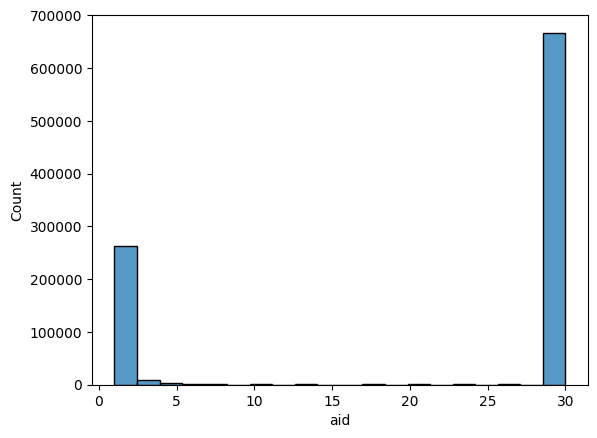

In [ ]:
sns.histplot(
    data=pred_df_buys_list.groupby('session', as_index=False).agg({'aid' : 'count'}),
    x='aid',
    bins=20
)

Noted that most users have 30 candidates selected. A few candidates do not, possibly due to them not having enough available information to select candidates.

In [ ]:
# pred_df_buys_list.to_parquet("/content/drive/MyDrive/0.capstone/covisit_prepare/ranker_candidates_train_3.parquet", index=False)